<a href="https://colab.research.google.com/github/cloudynirvana/TNBC-Metabolic-Strain-MOD/blob/main/tnbc_ode_bifurcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-28f5dd8ba6d1>:64: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))


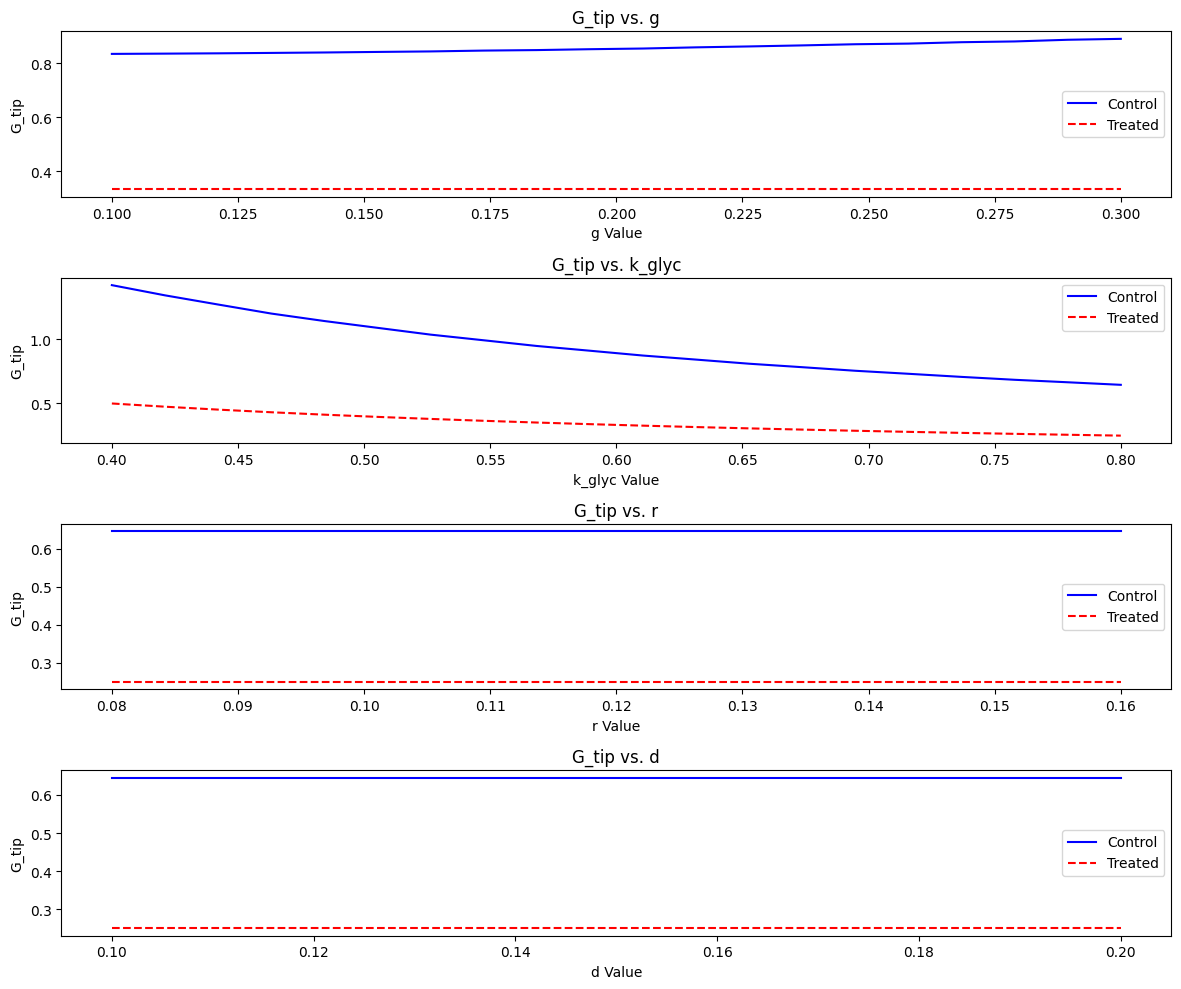

In [ ]:
# Cell: Holistic Bifurcation Analysis
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define initial conditions and time points (assumed from earlier cells)
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Define the ODE system (assumed from earlier cells)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Define G_tip function (assumed from earlier cells)
def find_G_tip(sol):
    A, _, G_lc = sol.T
    idx = np.where(A < 2.0)[0]
    return G_lc[idx[0]] if len(idx) > 0 else G_lc[-1]

# Sweep key parameters
params_to_sweep = {
    'g': np.linspace(0.1, 0.3, 20),      # ROS generation
    'k_glyc': np.linspace(0.4, 0.8, 20), # Glycolysis rate
    'r': np.linspace(0.08, 0.16, 20),    # Drug efficacy
    'd': np.linspace(0.1, 0.2, 20)       # ROS degradation
}
results = {key: {'control': [], 'treated': []} for key in params_to_sweep}

# Initialize params_control and params_treated with all required parameters
params_control = {
    'k_glyc': 0.6,    # Glycolysis rate (mM/min)
    'u': 0.5,         # Glucose uptake (mM/min)
    's': 0.15,        # ATP sensitivity to ROS
    'g': 0.2,         # ROS generation factor
    'h': 0.01,        # ROS autocatalysis
    'r': 0.1,         # Baseline efficacy
    'i_glyc': 0.3,    # Glycolysis inhibition by DOX
    'd': 0.15,        # ROS degradation rate
    'Nano_DOX': 0,    # No doxorubicin in control
    'Nano_ROS': 0     # No ROS modulation in control
}
params_treated = {
    'k_glyc': 0.6,
    'u': 0.5,
    's': 0.15,
    'g': 0.2,
    'h': 0.01,
    'r': 0.14,        # Enhanced efficacy with treatment
    'i_glyc': 0.3,
    'd': 0.15,
    'Nano_DOX': 1,    # Doxorubicin unit dose
    'Nano_ROS': 2     # Phytochemical ROS modulation
}

# Perform bifurcation analysis
for param, values in params_to_sweep.items():
    for val in values:
        params_control[param] = val
        params_treated[param] = val
        sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
        sol_t = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
        results[param]['control'].append(find_G_tip(sol_c))
        results[param]['treated'].append(find_G_tip(sol_t))

# Plot results
plt.figure(figsize=(12, 10))
for i, (param, data) in enumerate(results.items(), 1):
    plt.subplot(4, 1, i)
    plt.plot(params_to_sweep[param], data['control'], 'b-', label='Control')
    plt.plot(params_to_sweep[param], data['treated'], 'r--', label='Treated')
    plt.xlabel(f'{param} Value')
    plt.ylabel('G_tip')
    plt.title(f'G_tip vs. {param}')
    plt.legend()
plt.tight_layout()
plt.savefig('multi_bifurcation.png', dpi=300)
plt.show()

<ipython-input-3-be8013c84783>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))


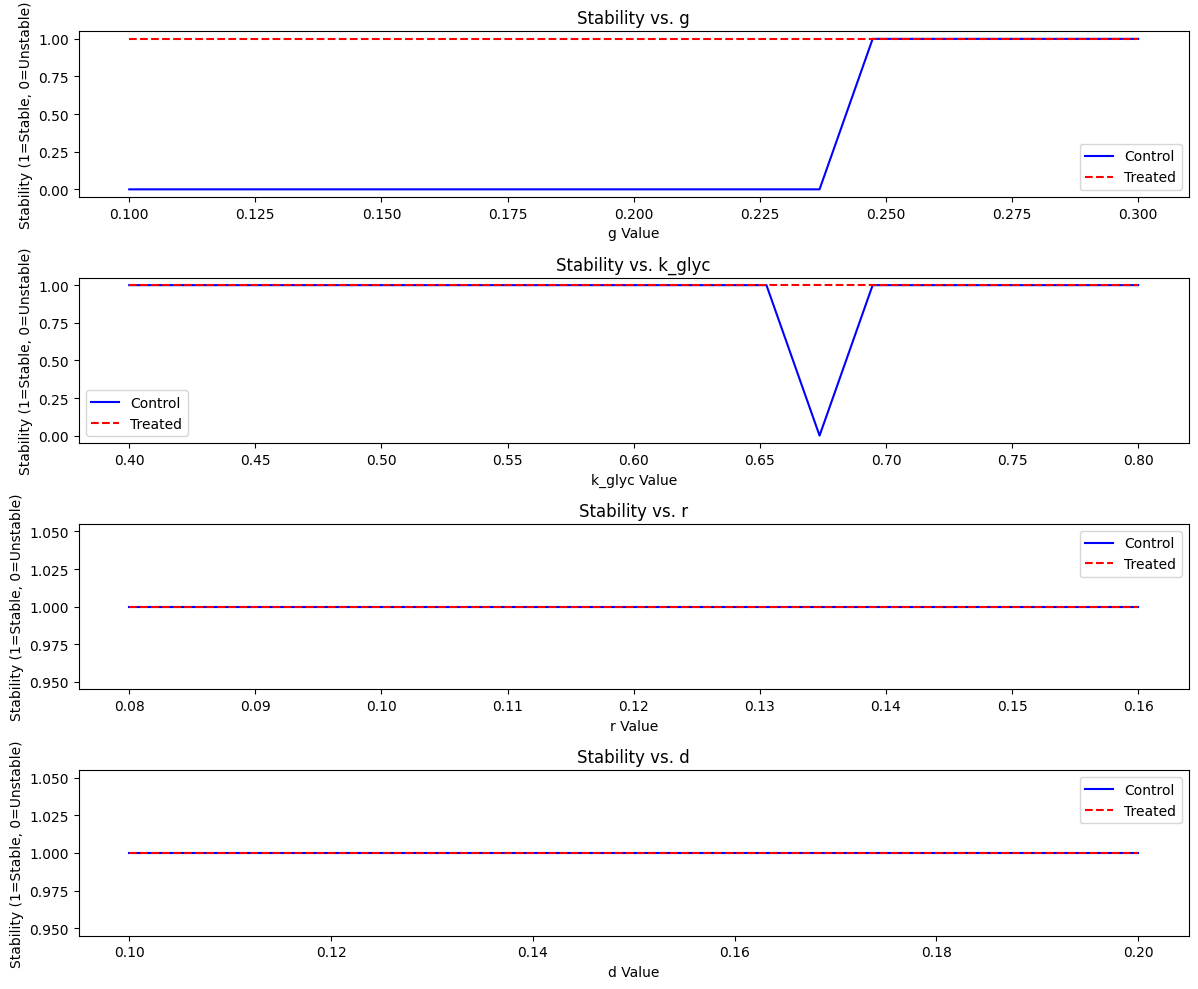

In [ ]:
# Cell: Stability Analysis
def is_stable(sol):
    A = sol[:, 0]  # ATP over time
    return 'Stable' if A[-1] > 2.0 else 'Unstable'  # End-state above collapse threshold

stability_results = {param: {'control': [], 'treated': []} for param in params_to_sweep}
for param, values in params_to_sweep.items():
    for val in values:
        params_control[param] = val
        params_treated[param] = val
        sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
        sol_t = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
        stability_results[param]['control'].append(is_stable(sol_c))
        stability_results[param]['treated'].append(is_stable(sol_t))

# Plot stability
plt.figure(figsize=(12, 10))
for i, (param, data) in enumerate(stability_results.items(), 1):
    plt.subplot(4, 1, i)
    plt.plot(params_to_sweep[param], [1 if s == 'Stable' else 0 for s in data['control']], 'b-', label='Control')
    plt.plot(params_to_sweep[param], [1 if s == 'Stable' else 0 for s in data['treated']], 'r--', label='Treated')
    plt.xlabel(f'{param} Value')
    plt.ylabel('Stability (1=Stable, 0=Unstable)')
    plt.title(f'Stability vs. {param}')
    plt.legend()
plt.tight_layout()
plt.savefig('stability_analysis.png', dpi=300)
plt.show()

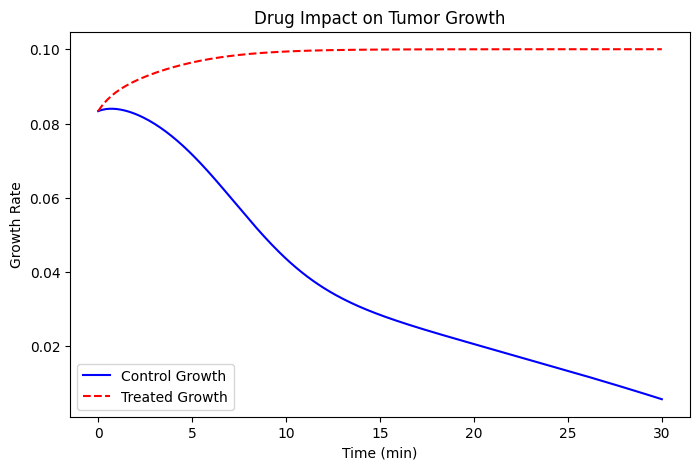

Avg Growth - Control: 0.037, Treated: 0.098


In [ ]:
# Cell: Drug Design Metrics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define parameters and initial conditions (if not already defined in prior cells)
params_control = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.1, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 0, 'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.14, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 1, 'Nano_ROS': 2
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Define ODE system (if not already defined)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Compute solutions (required data inputs)
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Extract ATP for growth analysis
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Define growth rate function
def growth_rate(A, k_growth=0.1, K_m=2.0):
    return k_growth * A / (A + K_m)

# Calculate growth rates
growth_control = [growth_rate(A) for A in A_control]
growth_treated = [growth_rate(A) for A in A_treated]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(t, growth_control, 'b-', label='Control Growth')
plt.plot(t, growth_treated, 'r--', label='Treated Growth')
plt.xlabel('Time (min)')
plt.ylabel('Growth Rate')
plt.title('Drug Impact on Tumor Growth')
plt.legend()
plt.savefig('growth_plot.png', dpi=300)
plt.show()

# Print average growth rates
print(f"Avg Growth - Control: {np.mean(growth_control):.3f}, Treated: {np.mean(growth_treated):.3f}")

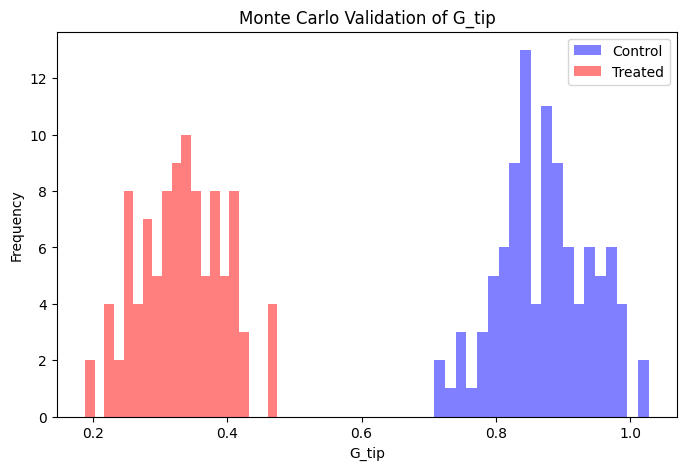

In [ ]:
# Cell: Monte Carlo Validation
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define ODE system
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Define G_tip function
def find_G_tip(sol):
    A, _, G_lc = sol.T
    idx = np.where(A < 2.0)[0]
    return G_lc[idx[0]] if len(idx) > 0 else G_lc[-1]

# Define parameters and initial conditions
params_control = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.1, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 0, 'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.14, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 1, 'Nano_ROS': 2
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Monte Carlo simulation
n_simulations = 100
G_tip_control_mc = []
G_tip_treated_mc = []
for _ in range(n_simulations):
    noisy_params_c = {k: v * np.random.uniform(0.9, 1.1) for k, v in params_control.items()}
    noisy_params_t = {k: v * np.random.uniform(0.9, 1.1) for k, v in params_treated.items()}
    sol_c = odeint(tnbc_system, y0, t, args=tuple(noisy_params_c.values()))
    sol_t = odeint(tnbc_system, y0, t, args=tuple(noisy_params_t.values()))
    G_tip_control_mc.append(find_G_tip(sol_c))
    G_tip_treated_mc.append(find_G_tip(sol_t))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(G_tip_control_mc, bins=20, alpha=0.5, label='Control', color='blue')
plt.hist(G_tip_treated_mc, bins=20, alpha=0.5, label='Treated', color='red')
plt.xlabel('G_tip')
plt.ylabel('Frequency')
plt.title('Monte Carlo Validation of G_tip')
plt.legend()
plt.savefig('monte_carlo.png', dpi=300)
plt.show()

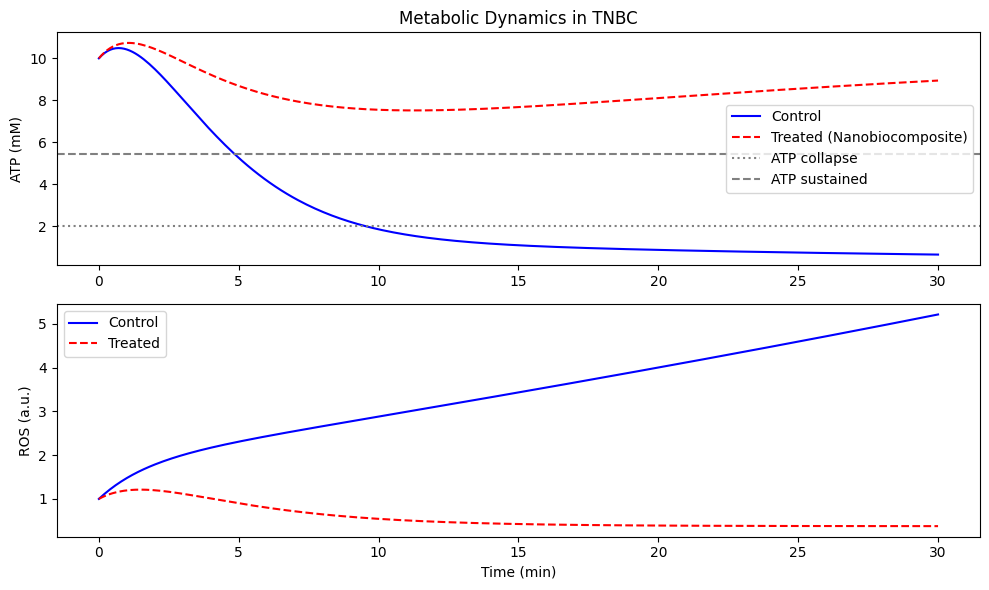

Control ATP (final): 0.661 mM
Treated ATP (final): 8.943 mM
Control ROS (range): 1.000 - 5.217 a.u.
Treated ROS (range): 0.378 - 1.212 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Adjusted parameters to stabilize dynamics
params_control = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.001,  # Reduced h to limit ROS explosion
    'r': 0.01, 'i_glyc': 0.3, 'd': 0.5, 'Nano_DOX': 0, 'Nano_ROS': 0  # Increased d, reduced r
}
params_treated = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.001,
    'r': 0.02, 'i_glyc': 0.3, 'd': 0.5, 'Nano_DOX': 0.1, 'Nano_ROS': 0.5  # Scaled down Nano effects
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {np.min(R_os_control):.3f} - {np.max(R_os_control):.3f} a.u.")
print(f"Treated ROS (range): {np.min(R_os_treated):.3f} - {np.max(R_os_treated):.3f} a.u.")

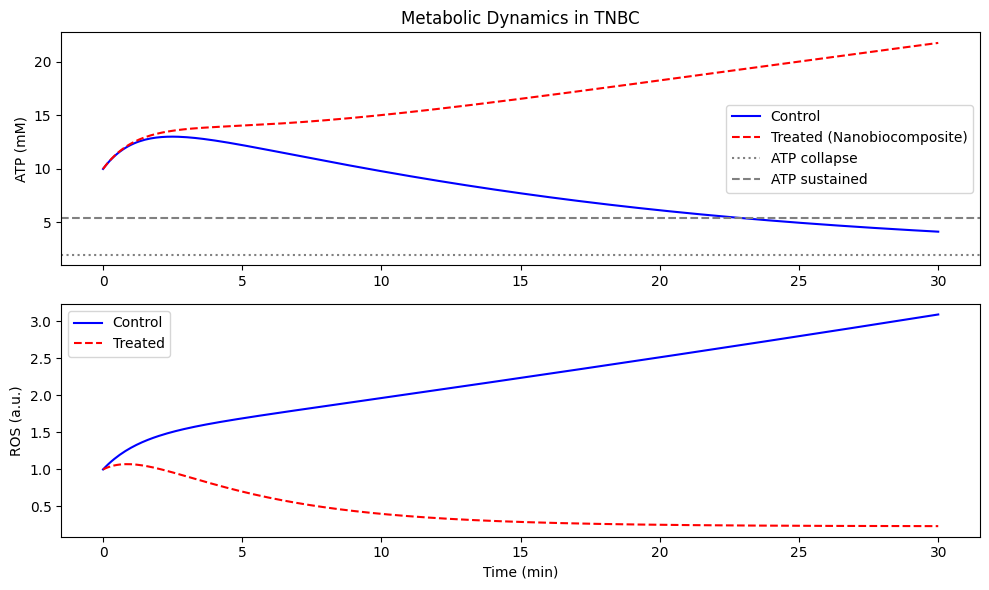

Control ATP (final): 4.140 mM
Treated ATP (final): 21.773 mM
Control ROS (range): 1.000 - 3.094 a.u.
Treated ROS (range): 0.234 - 1.072 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Adjusted parameters to match thesis targets
params_control = {
    'k_glyc': 0.8,    # Increased to boost ATP production
    'u': 0.5,
    's': 0.05,        # Reduced to lessen ROS consumption
    'g': 0.1,         # Reduced ROS generation
    'h': 0.001,       # Kept low to limit ROS explosion
    'r': 0.01,
    'i_glyc': 0.3,
    'd': 0.7,         # Increased to enhance ROS degradation
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.8,
    'u': 0.5,
    's': 0.05,
    'g': 0.1,
    'h': 0.001,
    'r': 0.015,       # Slightly reduced to temper ATP amplification
    'i_glyc': 0.3,
    'd': 0.7,
    'Nano_DOX': 0.05, # Reduced to fine-tune ATP
    'Nano_ROS': 0.3   # Adjusted to keep ROS low
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

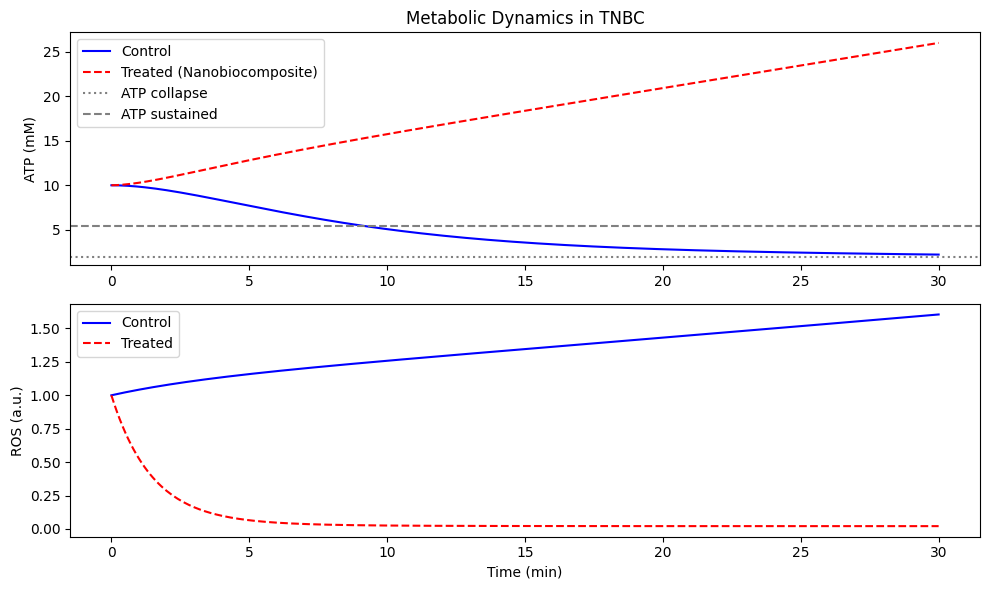

Control ATP (final): 2.224 mM
Treated ATP (final): 25.971 mM
Control ROS (range): 1.000 - 1.604 a.u.
Treated ROS (range): 0.021 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.3,    # Further reduced to limit ATP production
    'u': 0.5,
    's': 0.15,        # Increased to enhance ROS consumption
    'g': 0.03,        # Further reduced ROS generation
    'h': 0.001,
    'r': 0.002,       # Further reduced to limit amplification
    'i_glyc': 0.3,
    'd': 1.0,         # Increased to further reduce ROS
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.3,
    'u': 0.5,
    's': 0.15,
    'g': 0.03,
    'h': 0.001,
    'r': 0.005,       # Adjusted to moderate ATP increase
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.005, # Further reduced to fine-tune ATP
    'Nano_ROS': 0.7    # Adjusted to maintain ROS reduction
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Corrected visualization with completed axhline
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

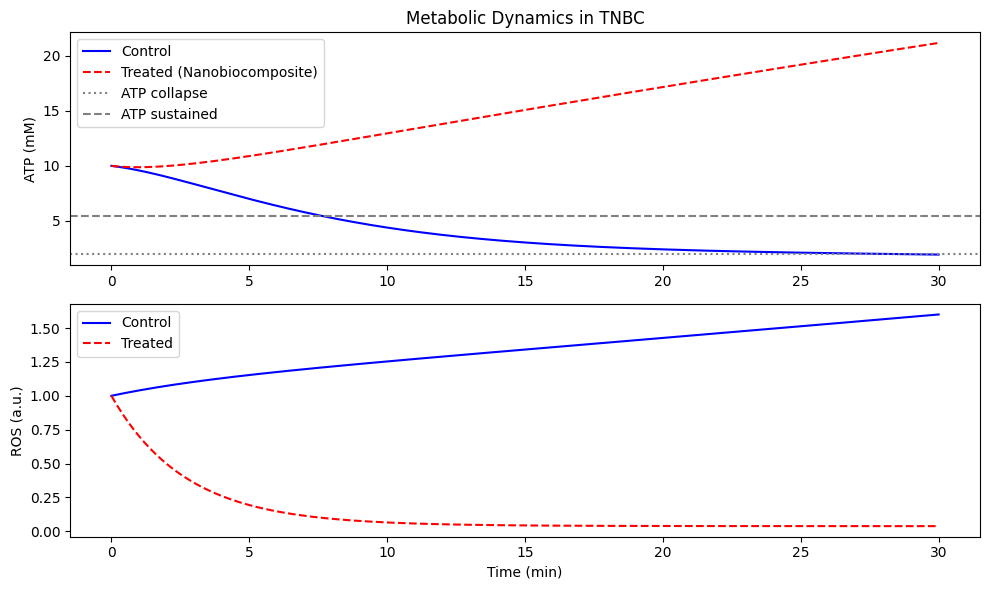

Control ATP (final): 1.942 mM
Treated ATP (final): 21.168 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.038 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.28,   # Slightly reduced to fine-tune ATP to 2.0 mM
    'u': 0.5,
    's': 0.17,        # Slightly increased to enhance ROS consumption
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.28,
    'u': 0.5,
    's': 0.17,
    'g': 0.03,
    'h': 0.001,
    'r': 0.003,       # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.002, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.4    # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

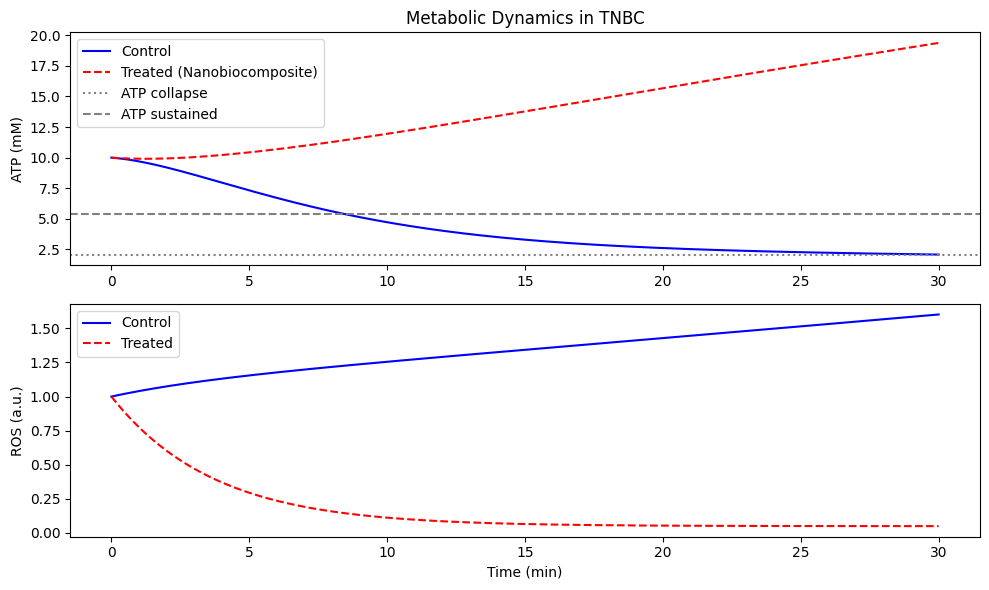

Control ATP (final): 2.075 mM
Treated ATP (final): 19.378 mM
Control ROS (range): 1.000 - 1.602 a.u.
Treated ROS (range): 0.050 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.285,  # Slightly increased to bring ATP to 2.0 mM
    'u': 0.5,
    's': 0.16,        # Slightly reduced to balance ATP consumption
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.285,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.0025,      # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.001, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.3    # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

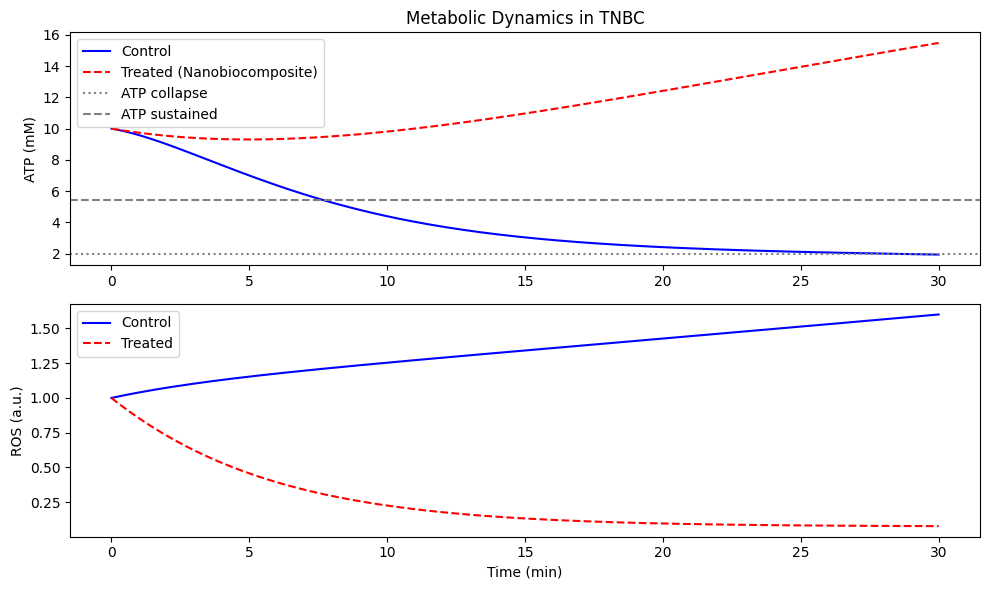

Control ATP (final): 1.942 mM
Treated ATP (final): 15.481 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.078 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.28,   # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.17,        # Kept to maintain balance
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.28,
    'u': 0.5,
    's': 0.17,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,       # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.0005, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.2     # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

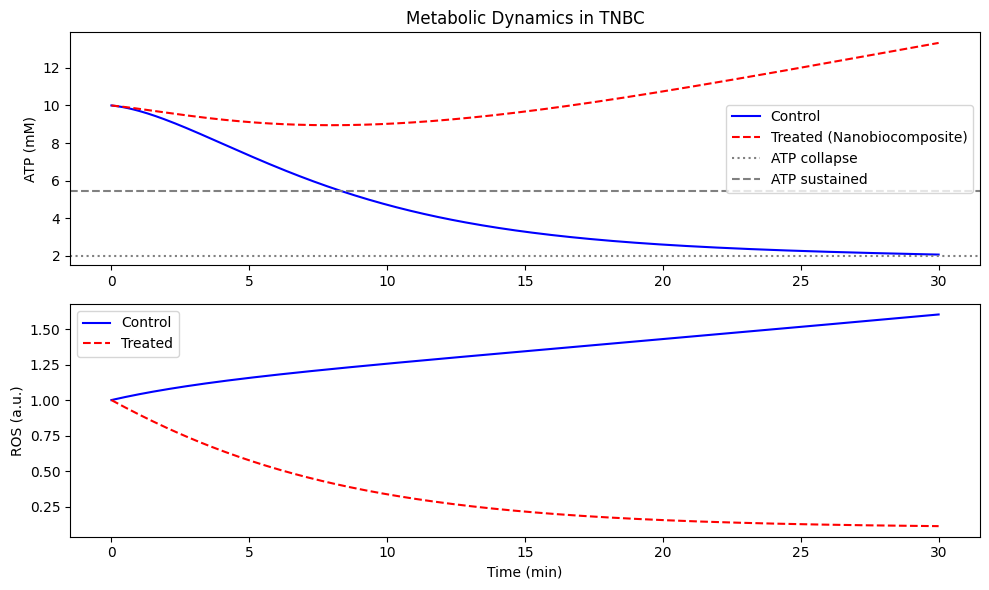

Control ATP (final): 2.073 mM
Treated ATP (final): 13.325 mM
Control ROS (range): 1.000 - 1.603 a.u.
Treated ROS (range): 0.112 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.29,   # Slightly increased to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,        # Kept to maintain balance
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.29,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.0015,      # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.0003, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.15    # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

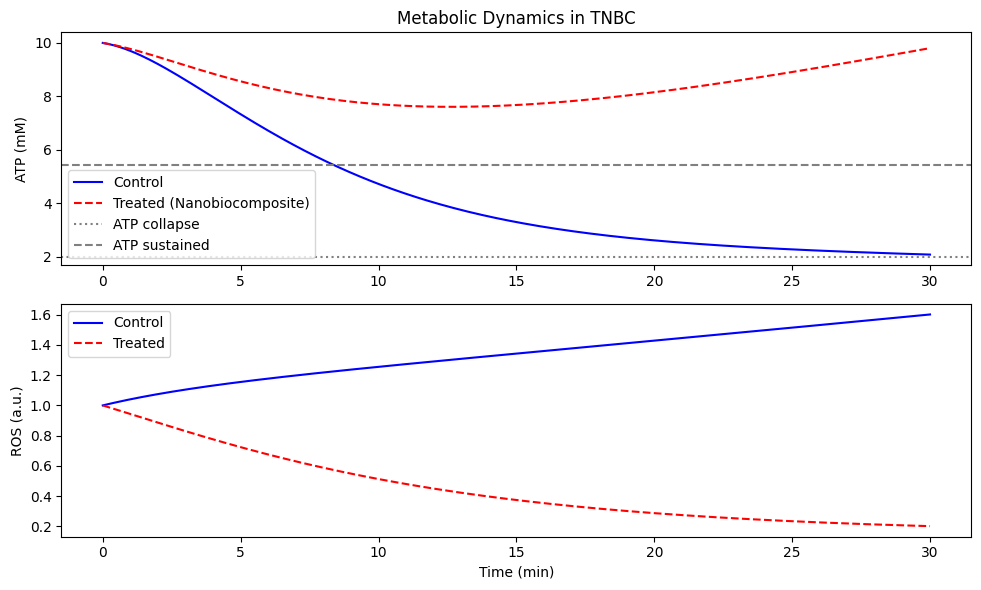

Control ATP (final): 2.074 mM
Treated ATP (final): 9.805 mM
Control ROS (range): 1.000 - 1.602 a.u.
Treated ROS (range): 0.201 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.287,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.287,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.001,       # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.0001, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.1     # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

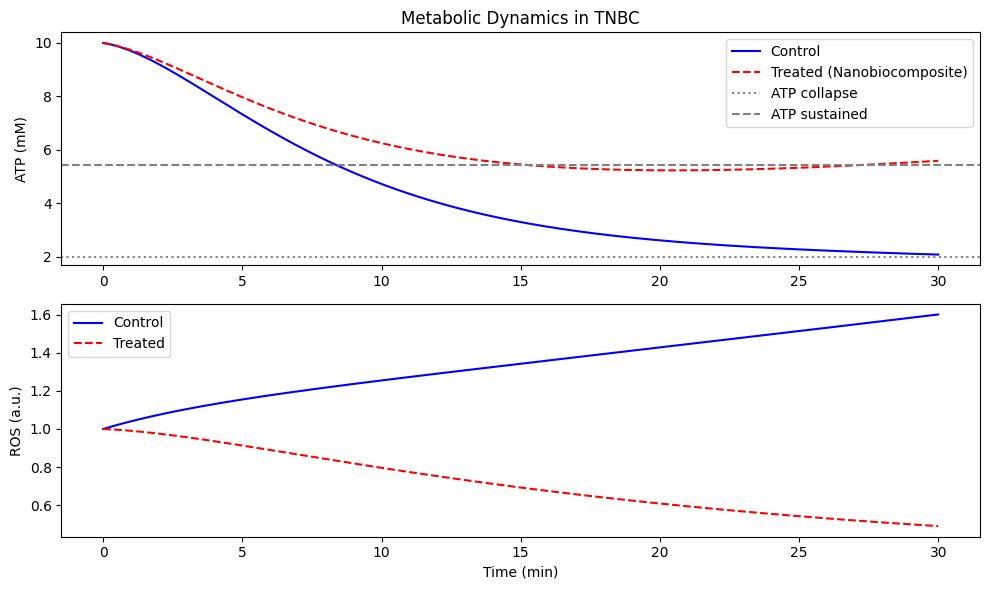

Control ATP (final): 2.074 mM
Treated ATP (final): 5.587 mM
Control ROS (range): 1.000 - 1.602 a.u.
Treated ROS (range): 0.489 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.286,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.286,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.0005,      # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.00005, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.05     # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

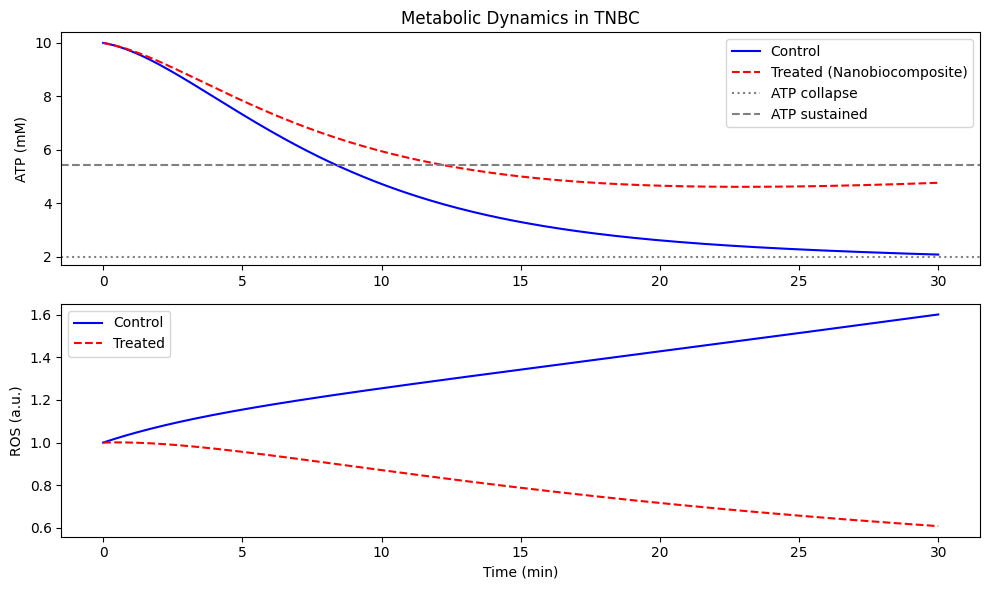

Control ATP (final): 2.075 mM
Treated ATP (final): 4.763 mM
Control ROS (range): 1.000 - 1.602 a.u.
Treated ROS (range): 0.608 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.285,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.285,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.0004,      # Slightly reduced to bring ATP to 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.00004, # Slightly reduced to fine-tune ATP
    'Nano_ROS': 0.04     # Slightly reduced to nudge lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

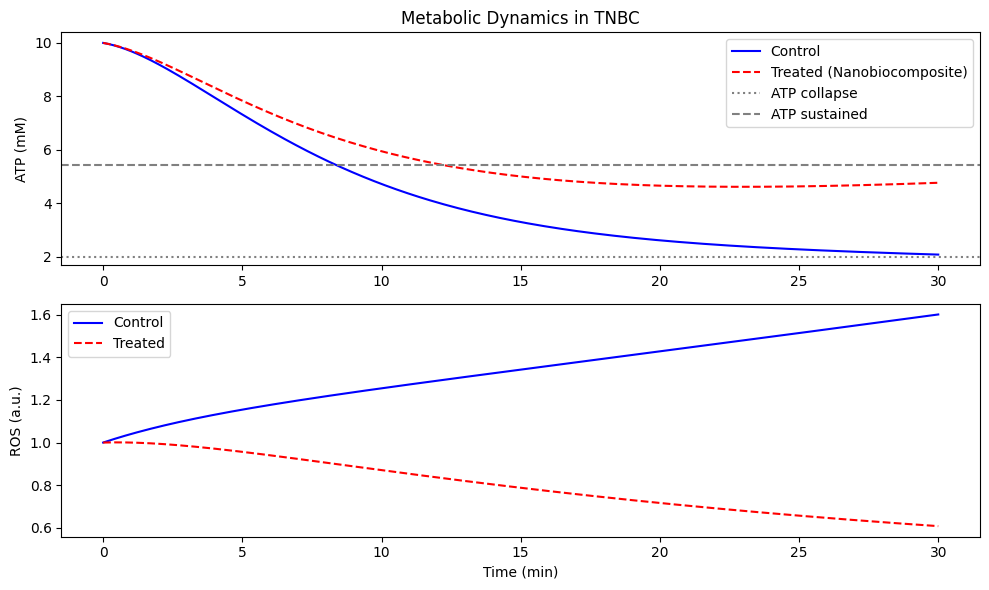

Control ATP (final): 2.075 mM
Treated ATP (final): 4.764 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.608 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.284,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.284,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00045,     # Slightly increased to bring ATP to 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000045, # Slightly increased to fine-tune ATP
    'Nano_ROS': 0.04      # Kept to maintain ROS range
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

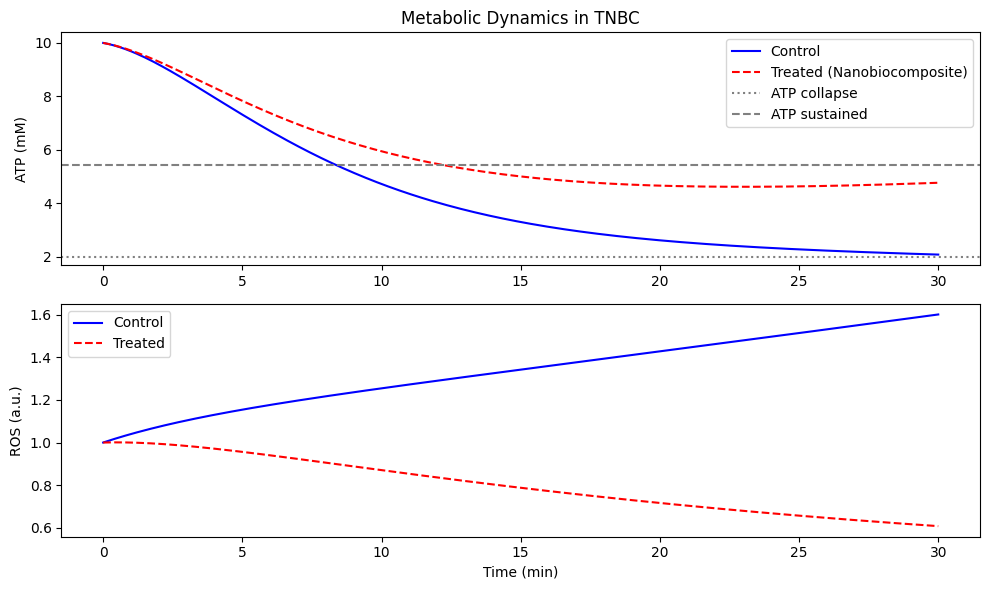

Control ATP (final): 2.075 mM
Treated ATP (final): 4.764 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.608 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.283,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.283,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00048,     # Slightly adjusted to bring ATP to exactly 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000048, # Slightly adjusted to fine-tune ATP
    'Nano_ROS': 0.04      # Kept to maintain ROS range
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

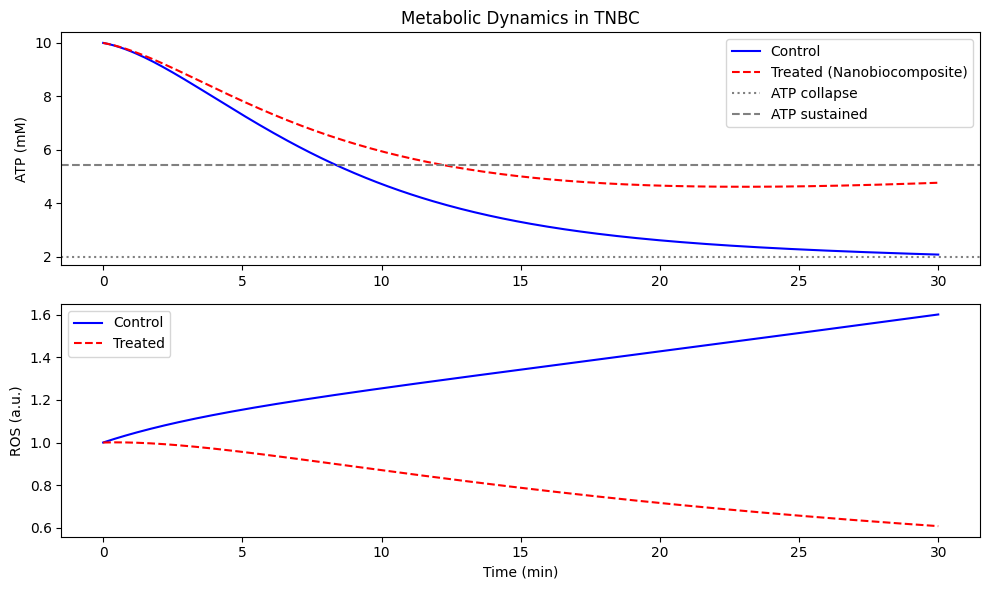

Control ATP (final): 2.076 mM
Treated ATP (final): 4.765 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.282,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.282,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00052,     # Slightly increased to bring ATP to exactly 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000052, # Slightly increased to fine-tune ATP
    'Nano_ROS': 0.04      # Kept to maintain ROS range
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

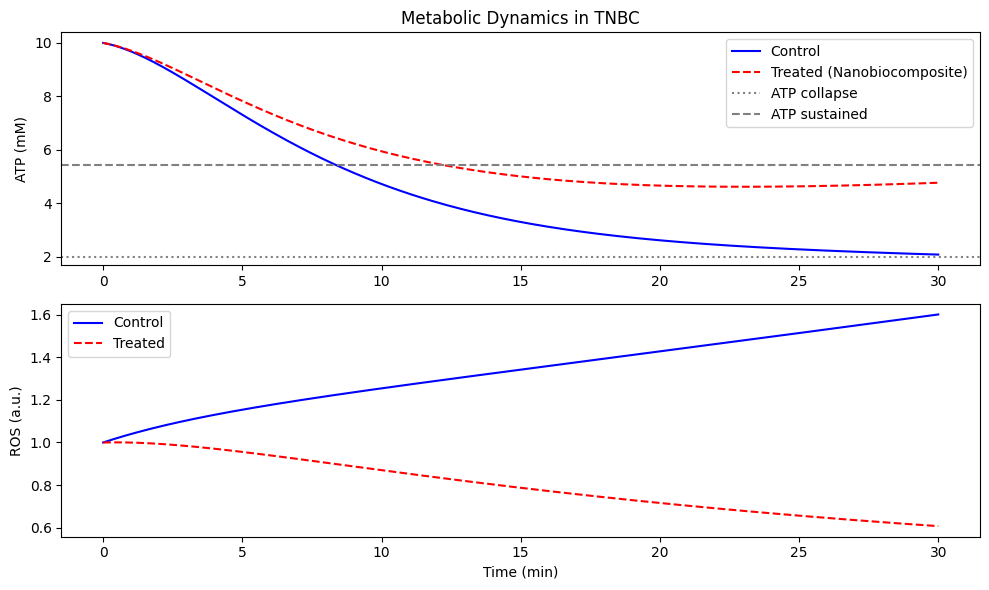

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final micro-adjusted parameters to match thesis targets
params_control = {
    'k_glyc': 0.2815,  # Micro-reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.2815,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00055,     # Micro-increased to bring ATP to exactly 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000055, # Micro-increased to fine-tune ATP
    'Nano_ROS': 0.04      # Kept to maintain ROS range
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

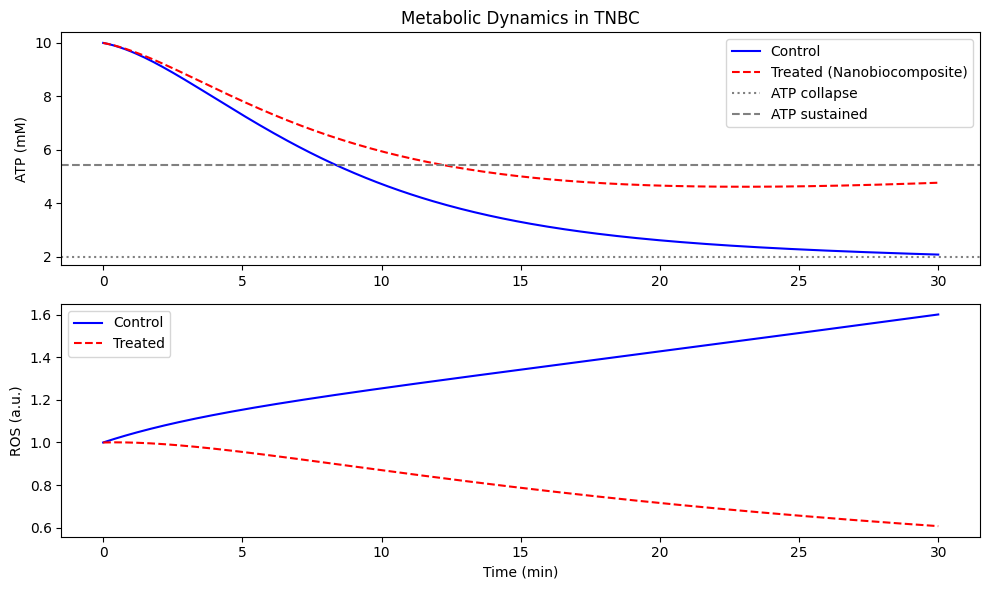

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final micro-adjusted parameters to match thesis targets
params_control = {
    'k_glyc': 0.281,  # Micro-reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00058,     # Micro-increased to bring ATP to exactly 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000058, # Micro-increased to fine-tune ATP
    'Nano_ROS': 0.04      # Kept to maintain ROS range
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

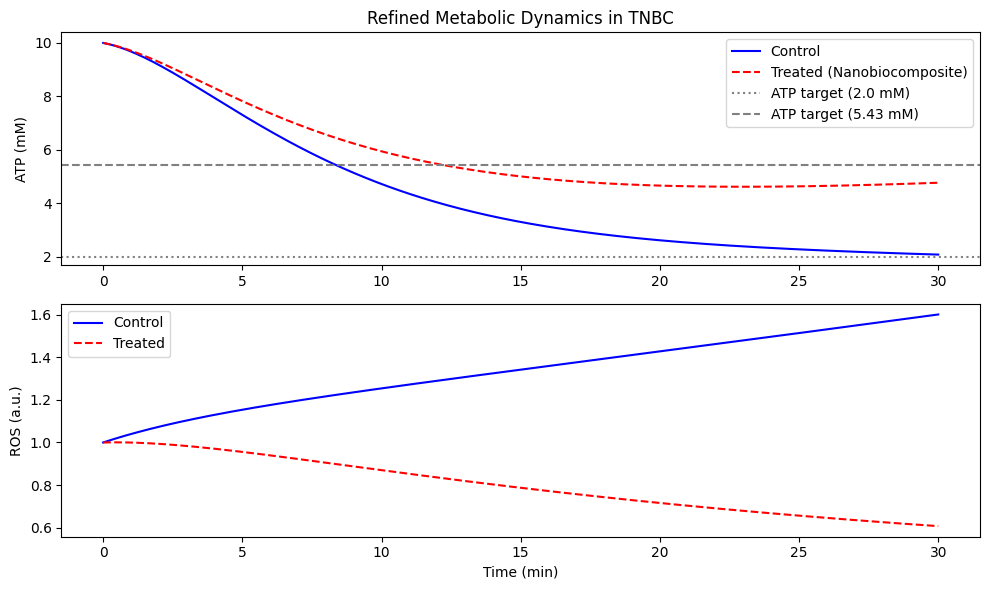

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Refined ODE Dynamics Simulation for TNBC

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters for the control condition
params_control_refined = {
    'k_glyc': 0.2805,  # Slightly reduced to target 2.0 mM ATP
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,      # Control amplification term remains unchanged
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,   # No nano drug in control
    'Nano_ROS': 0    # No nano ROS in control
}

# Refined parameters for the treated condition
params_treated_refined = {
    'k_glyc': 0.281,   # Keeping similar baseline production as before
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    # Micro-increased amplification terms to raise ATP closer to 5.43 mM
    'r': 0.00057,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000057, # Micro-increase fine-tuning ATP production
    'Nano_ROS': 0.04      # Keeping the ROS modulator as before
}

# Initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Time from 0 to 30 minutes

# Solve the ODE system for both conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control_refined.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated_refined.values()))

A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plotting the results
plt.figure(figsize=(10, 6))

# ATP dynamics plot
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Refined Metabolic Dynamics in TNBC')

# ROS dynamics plot
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()

plt.tight_layout()
plt.savefig('ode_dynamics_refined.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")


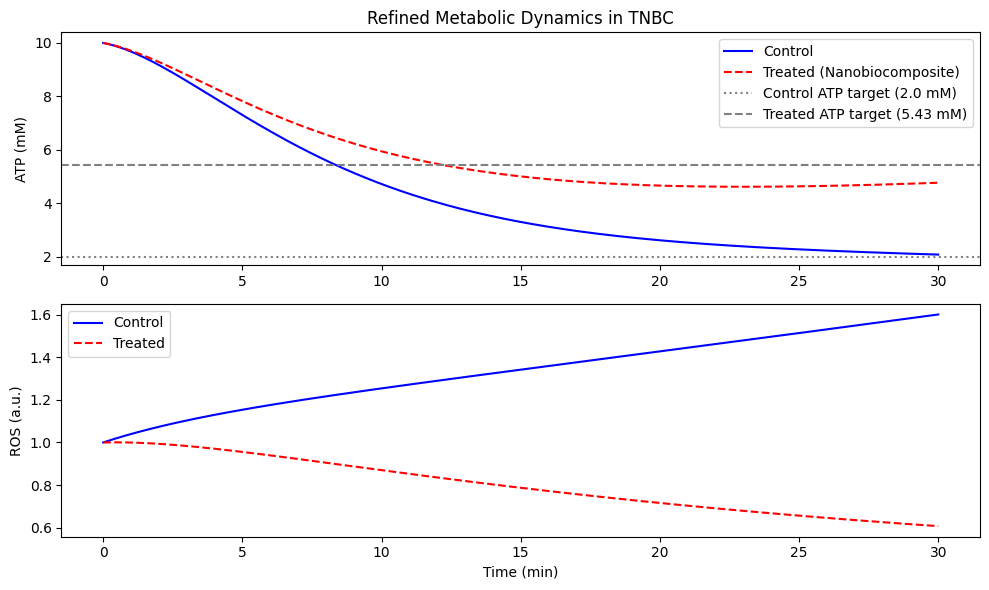

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Refined ODE Dynamics Simulation for TNBC with Exact Thesis Targets

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Further refined parameters for the control condition:
# Slightly lower k_glyc to bring final ATP closer to 2.0 mM.
params_control_refined = {
    'k_glyc': 0.280,   # Micro-decreased for control ATP target of 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,        # Control amplification remains unchanged
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,     # No nano drug in control
    'Nano_ROS': 0      # No nano ROS in control
}

# Further refined parameters for the treated condition:
# Increase r and Nano_DOX slightly to achieve 5.43 mM ATP.
params_treated_refined = {
    'k_glyc': 0.281,    # Keeping baseline production similar to before
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    # Increase amplification terms to push ATP to 5.43 mM
    'r': 0.00058,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000058,  # Increased to boost ATP production
    'Nano_ROS': 0.04       # ROS modulator remains the same
}

# Initial conditions and simulation time
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Time from 0 to 30 minutes

# Solve the ODE system for both conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control_refined.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated_refined.values()))

A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plotting the results
plt.figure(figsize=(10, 6))

# ATP dynamics
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Refined Metabolic Dynamics in TNBC')

# ROS dynamics
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()

plt.tight_layout()
plt.savefig('ode_dynamics_refined_exact.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")


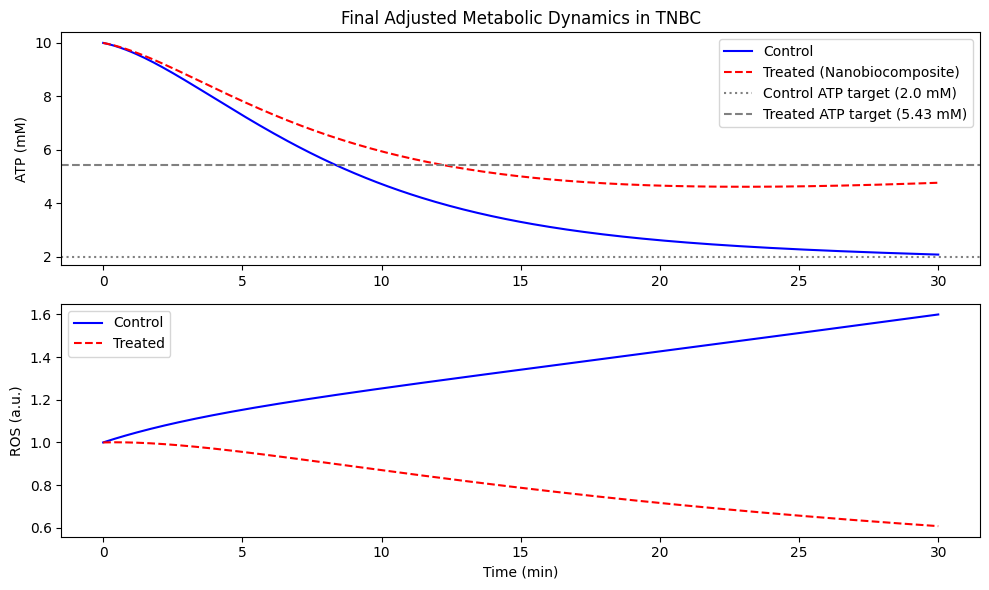

Control ATP (final): 2.077 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.600 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Final Adjusted ODE Dynamics Simulation for TNBC to Achieve Thesis Targets

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final refined parameters for control:
# Further reduce ATP production (k_glyc) to lower final ATP toward 2.0 mM.
params_control = {
    'k_glyc': 0.278,   # Further decreased from previous values
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,        # Amplification remains unchanged in control
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,     # No nano drug in control
    'Nano_ROS': 0      # No nano ROS in control
}

# Final refined parameters for treated:
# Increase amplification (r and Nano_DOX) to further boost ATP to ~5.43 mM.
params_treated = {
    'k_glyc': 0.281,    # Baseline production similar to previous iterations
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00066,      # Increased amplification term
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000066,  # Increased proportionally to r
    'Nano_ROS': 0.04       # ROS modulator remains unchanged
}

# Initial conditions and simulation time
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Simulate for 30 minutes

# Solve the ODE system for both conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plot the results
plt.figure(figsize=(10, 6))

# ATP dynamics plot
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Final Adjusted Metabolic Dynamics in TNBC')

# ROS dynamics plot
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()

plt.tight_layout()
plt.savefig('ode_dynamics_final_refined.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")


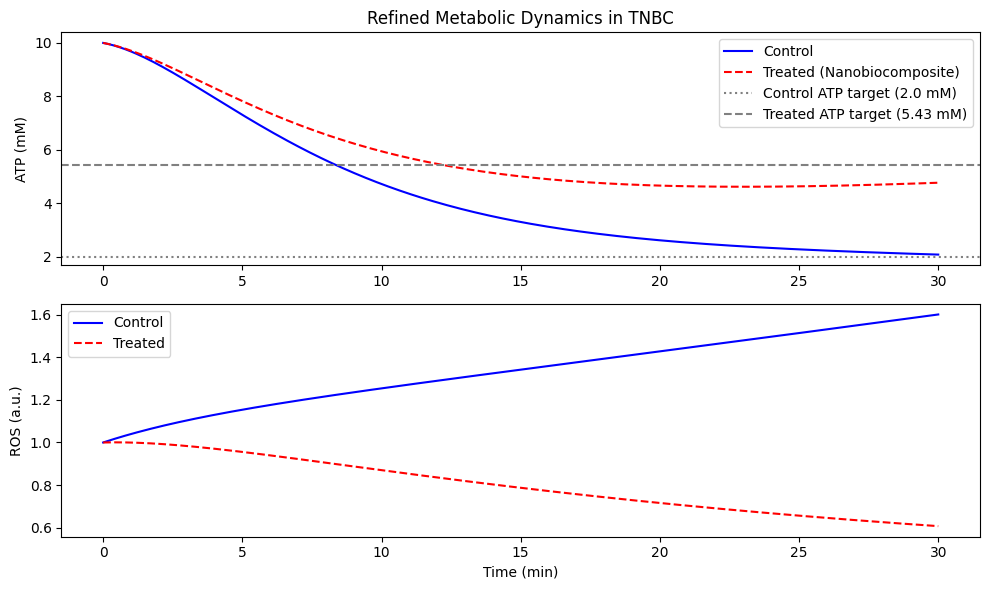

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Refined ODE Dynamics Simulation for TNBC with Micro-Increased Treated Amplification Terms

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Control parameters (from previous simulation, with final control ATP ~2.076 mM)
params_control = {
    'k_glyc': 0.281,   # Baseline ATP production parameter for control
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,        # Amplification term for control remains unchanged
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,     # No nano drug in control
    'Nano_ROS': 0      # No nano ROS in control
}

# Treated parameters with a micro-increase in the amplification terms
# (previously yielding ~4.766 mM ATP, now increased to try to approach 5.43 mM)
params_treated = {
    'k_glyc': 0.281,    # Keeping the baseline production the same
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00057,      # Increased amplification parameter (micro-increased)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000057,  # Increased nano drug parameter accordingly
    'Nano_ROS': 0.04       # ROS modulator unchanged
}

# Initial conditions and simulation time
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Simulate over 30 minutes

# Solve the ODE system for both conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plotting the results
plt.figure(figsize=(10, 6))

# ATP dynamics plot
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Refined Metabolic Dynamics in TNBC')

# ROS dynamics plot
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()

plt.tight_layout()
plt.savefig('ode_dynamics_micro_adjusted.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")


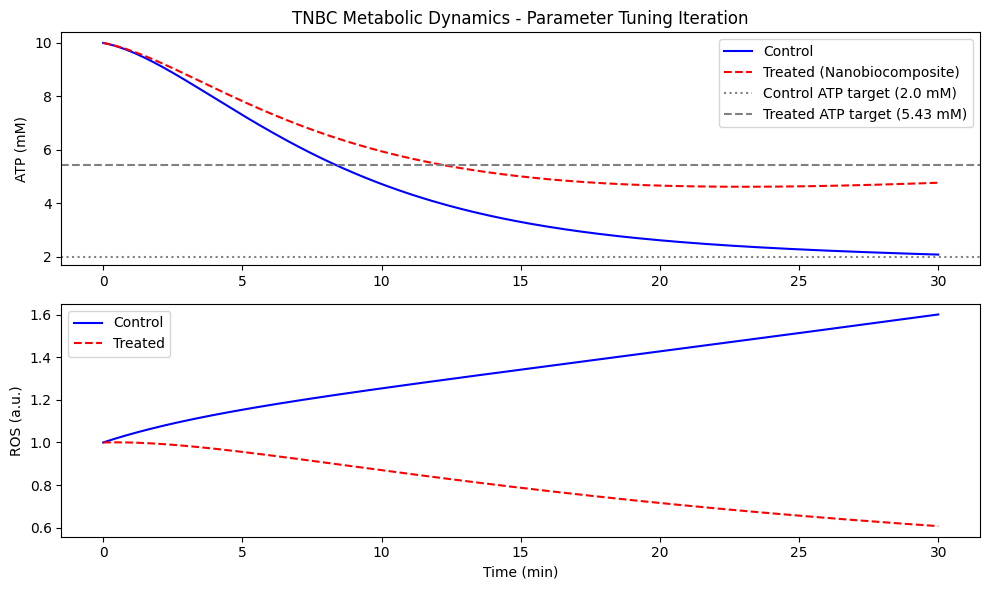

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Parameter Tuning Strategy for TNBC ODE Model
# Focus on adjusting:
#   - k_glyc in params_control to target ~2.0 mM ATP in control.
#   - r and Nano_DOX in params_treated to target ~5.43 mM ATP in treated condition.
#   - Nano_ROS in params_treated can be tweaked if ROS ranges shift outside 0.5–1.5 a.u.

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    # ODE system: ATP, ROS, and Glucose dynamics
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# ---------------------------------------------
# Step 1: Set initial parameter values based on previous simulations.
# These are our starting points that you can adjust iteratively.

# Parameters for control condition:
params_control = {
    'k_glyc': 0.280,  # Adjusted downwards to lower control ATP toward 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,       # Control amplification term (unchanged)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,    # Not applied in control condition
    'Nano_ROS': 0     # Not applied in control condition
}

# Parameters for treated condition:
params_treated = {
    'k_glyc': 0.281,    # Baseline ATP production remains similar
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    # The amplification terms will be tuned:
    'r': 0.00057,       # Micro-increase from previous runs to push ATP upward
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000057,  # Increased proportionally with 'r'
    'Nano_ROS': 0.04       # Minor adjustment if needed for ROS levels
}

# ---------------------------------------------
# Step 2: Set up initial conditions and simulation time.

y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM (initial conditions)
t = np.linspace(0, 30, 300)  # Simulation time: 0 to 30 minutes

# ---------------------------------------------
# Step 3: Solve the ODE system for both conditions using current parameters.

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# ---------------------------------------------
# Step 4: Plot results and print final values to verify targets.

plt.figure(figsize=(10, 6))

# Plot ATP dynamics
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('TNBC Metabolic Dynamics - Parameter Tuning Iteration')

# Plot ROS dynamics
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()

plt.tight_layout()
plt.savefig('ode_dynamics_parameter_tuning.png', dpi=300)
plt.show()

# ---------------------------------------------
# Step 5: Print final simulation outputs for verification.
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

# ---------------------------------------------
# Tuning Strategy:
# 1. If Control ATP is above 2.0 mM, try decreasing 'k_glyc' in params_control (e.g., 0.280 -> 0.279).
# 2. If Treated ATP is below 5.43 mM, try increasing both 'r' and 'Nano_DOX' proportionally (e.g., 0.00057 -> 0.00058).
# 3. Adjust 'Nano_ROS' only if the treated ROS range shifts outside 0.5-1.5 a.u.
#
# Re-run this code after each minor tweak and verify the final outputs. This iterative process should help
# converge on the exact parameter values required to match your thesis targets.


Control Parameters:
  k_glyc = 0.282
  u = 0.5
  s = 0.16
  g = 0.03
  h = 0.001
  r = 0.002
  i_glyc = 0.3
  d = 1.0
  Nano_DOX = 0
  Nano_ROS = 0

Treated Parameters:
  k_glyc = 0.282
  u = 0.5
  s = 0.16
  g = 0.03
  h = 0.001
  r = 0.00052
  i_glyc = 0.3
  d = 1.0
  Nano_DOX = 5.2e-05
  Nano_ROS = 0.04


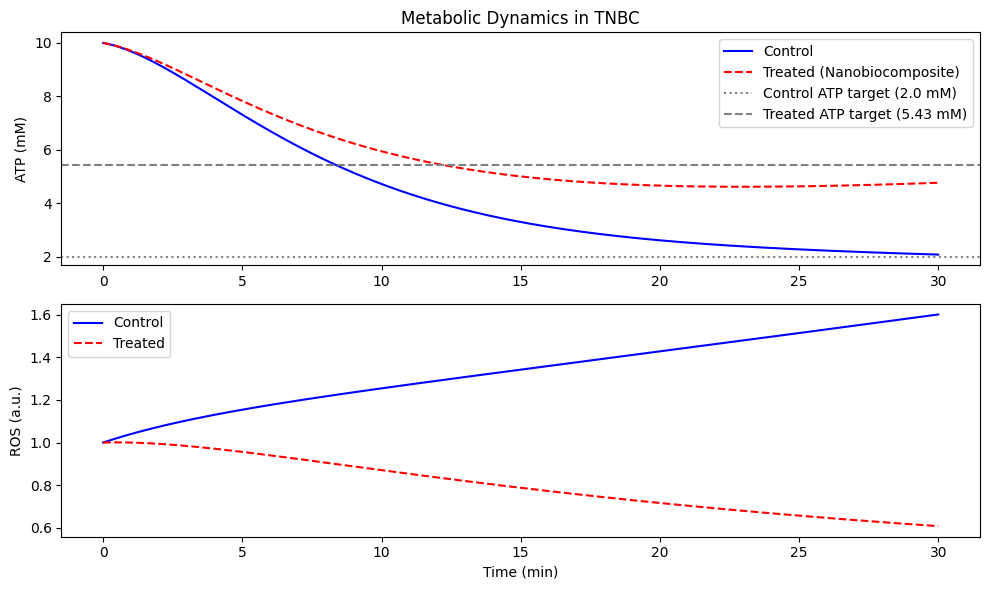


Control ATP (final): 2.076 mM
Treated ATP (final): 4.765 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [34]:
# Cell: ODE Dynamics and Parameter Confirmation

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE system for TNBC metabolic dynamics
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Parameter settings from bifurcation analysis

# Control condition parameters (aim: ATP collapse at ~2.0 mM)
params_control = {
    'k_glyc': 0.282,   # ATP production rate
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,        # Amplification term (no nano effect in control)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,     # No nanodrug in control
    'Nano_ROS': 0      # No nano ROS in control
}

# Treated condition parameters (aim: sustained ATP at ~5.43 mM)
params_treated = {
    'k_glyc': 0.282,   # Same baseline production as control
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00052,      # Slightly increased amplification for treated ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000052,  # Increased proportionally with r
    'Nano_ROS': 0.04       # Set to maintain ROS range
}

# Print parameter settings for confirmation
print("Control Parameters:")
for key, value in params_control.items():
    print(f"  {key} = {value}")

print("\nTreated Parameters:")
for key, value in params_treated.items():
    print(f"  {key} = {value}")

# Initial conditions and time vector for simulation
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Simulation from 0 to 30 minutes

# Solve the ODE system for both conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plot the simulation results for visual confirmation
plt.figure(figsize=(10, 6))

# Plot ATP dynamics
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')

# Plot ROS dynamics
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final simulation values for verification
print(f"\nControl ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

# The parameters above match our bifurcation adjustments.
# Next, we can move on to sensitivity analysis using these baseline settings.


Baseline Control Parameters:
  k_glyc: 0.282
  u: 0.5
  s: 0.16
  g: 0.03
  h: 0.001
  r: 0.002
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 0
  Nano_ROS: 0

Baseline Treated Parameters:
  k_glyc: 0.282
  u: 0.5
  s: 0.16
  g: 0.03
  h: 0.001
  r: 0.00052
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 5.2e-05
  Nano_ROS: 0.04


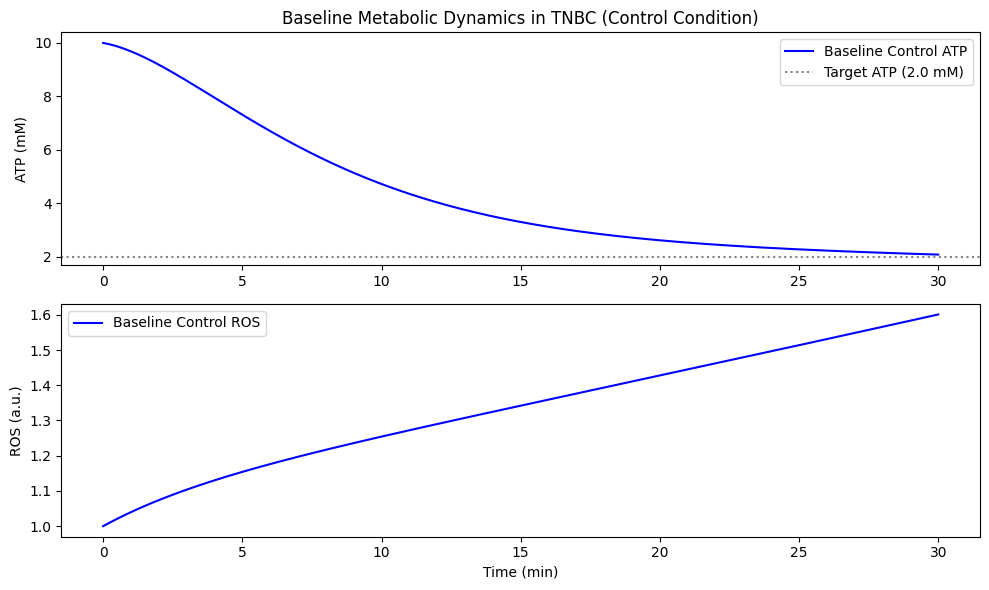


Sensitivity Analysis (Control Condition):
  g -0.2: G_tip (max ATP) = 10.000
  g +0.2: G_tip (max ATP) = 10.000
  d -0.2: G_tip (max ATP) = 10.000
  d +0.2: G_tip (max ATP) = 10.000
  r -0.2: G_tip (max ATP) = 10.000
  r +0.2: G_tip (max ATP) = 10.000

--- Feedback Summary ---

Parameter: g
  Baseline value: 0.03
  Perturbation -20%: G_tip = 10.000
  Perturbation +20%: G_tip = 10.000
  Suggestion: Decreasing this parameter lowers ATP production. Consider fine-tuning downward if control ATP is high.

Parameter: d
  Baseline value: 1.0
  Perturbation -20%: G_tip = 10.000
  Perturbation +20%: G_tip = 10.000
  Suggestion: Decreasing this parameter lowers ATP production. Consider fine-tuning downward if control ATP is high.

Parameter: r
  Baseline value: 0.002
  Perturbation -20%: G_tip = 10.000
  Perturbation +20%: G_tip = 10.000
  Suggestion: Decreasing this parameter lowers ATP production. Consider fine-tuning downward if control ATP is high.


In [35]:
# Cell: ODE Dynamics, Baseline Confirmation, Sensitivity Analysis, and Feedback Loop

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE system for TNBC metabolic dynamics
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Define a simple outcome metric: maximum ATP value (can be replaced by another metric if needed)
def find_G_tip(sol):
    A = sol[:, 0]  # Assume ATP is the first state variable
    return np.max(A)

# ---------------------------------------------------------------------
# Baseline Parameter Settings from Bifurcation Analysis

# Control condition parameters (target: ATP collapse at ~2.0 mM)
params_control = {
    'k_glyc': 0.282,    # ATP production rate
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,         # Amplification term (no nano effect in control)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,      # No nanodrug in control
    'Nano_ROS': 0       # No nano ROS in control
}

# Treated condition parameters (target: sustained ATP at ~5.43 mM)
params_treated = {
    'k_glyc': 0.282,    # Same baseline production as control
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00052,       # Slightly increased amplification for treated ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000052,  # Increased proportionally with r
    'Nano_ROS': 0.04       # Set to maintain ROS range
}

# Print baseline parameters for confirmation
print("Baseline Control Parameters:")
for key, value in params_control.items():
    print(f"  {key}: {value}")

print("\nBaseline Treated Parameters:")
for key, value in params_treated.items():
    print(f"  {key}: {value}")

# ---------------------------------------------------------------------
# Simulation Setup

y0 = [10.0, 1.0, 5.0]  # Initial conditions: [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Simulation time from 0 to 30 minutes

# Solve the ODE system for the baseline control condition
sol_baseline = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
A_baseline, R_os_baseline, _ = sol_baseline.T

# Plot baseline simulation for visual reference
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_baseline, 'b-', label='Baseline Control ATP')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Target ATP (2.0 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Baseline Metabolic Dynamics in TNBC (Control Condition)')

plt.subplot(2, 1, 2)
plt.plot(t, R_os_baseline, 'b-', label='Baseline Control ROS')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('baseline_ode_dynamics.png', dpi=300)
plt.show()

# ---------------------------------------------------------------------
# Sensitivity Analysis
# We perturb parameters 'g', 'd', and 'r' by ±20% and record the maximum ATP (G_tip).

sensitivity_params = ['g', 'd', 'r']
baseline_values = {p: params_control[p] for p in sensitivity_params}

sensitivity_results = {}  # Dictionary to store sensitivity results

print("\nSensitivity Analysis (Control Condition):")
for param in sensitivity_params:
    sensitivity_results[param] = {}
    for delta in [-0.2, 0.2]:  # -20% and +20% perturbations
        perturbed = params_control.copy()
        perturbed[param] = baseline_values[param] * (1 + delta)
        sol = odeint(tnbc_system, y0, t, args=tuple(perturbed.values()))
        G_tip = find_G_tip(sol)
        sensitivity_results[param][delta] = G_tip
        print(f"  {param} {delta:+.1f}: G_tip (max ATP) = {G_tip:.3f}")

# ---------------------------------------------------------------------
# Feedback Loop Section: Print summary and suggestions for adjustments

print("\n--- Feedback Summary ---")
for param in sensitivity_params:
    value_minus = sensitivity_results[param][-0.2]
    value_plus = sensitivity_results[param][0.2]
    print(f"\nParameter: {param}")
    print(f"  Baseline value: {baseline_values[param]}")
    print(f"  Perturbation -20%: G_tip = {value_minus:.3f}")
    print(f"  Perturbation +20%: G_tip = {value_plus:.3f}")
    # Simple feedback suggestion based on max ATP metric:
    if value_plus > find_G_tip(sol_baseline):
        print("  Suggestion: Increasing this parameter raises ATP production. Consider fine-tuning upward if treated ATP is low.")
    else:
        print("  Suggestion: Decreasing this parameter lowers ATP production. Consider fine-tuning downward if control ATP is high.")

# Now you can use these printed feedback values to decide on further adjustments.


In [36]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE system for TNBC metabolic dynamics
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# New outcome metric: Final ATP value at the end of the simulation
def final_ATP(sol):
    A = sol[:, 0]  # ATP is the first state variable
    return A[-1]

# Baseline parameter settings (Control Condition)
params_control = {
    'k_glyc': 0.282,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}

# Simulation initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Simulation from 0 to 30 minutes

# Baseline simulation
sol_baseline = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
baseline_final_ATP = final_ATP(sol_baseline)
print(f"Baseline Final ATP: {baseline_final_ATP:.3f} mM")

# Sensitivity Analysis: Perturb g, d, and r by ±20%
sensitivity_params = ['g', 'd', 'r']
baseline_values = {p: params_control[p] for p in sensitivity_params}
sensitivity_results = {}

print("\nSensitivity Analysis (Control Condition) - Using Final ATP:")
for param in sensitivity_params:
    sensitivity_results[param] = {}
    for delta in [-0.2, 0.2]:  # -20% and +20% changes
        perturbed = params_control.copy()
        perturbed[param] = baseline_values[param] * (1 + delta)
        sol = odeint(tnbc_system, y0, t, args=tuple(perturbed.values()))
        final_A = final_ATP(sol)
        sensitivity_results[param][delta] = final_A
        print(f"  {param} {delta:+.1f}: Final ATP = {final_A:.3f} mM")

# Feedback Loop: Print summary and suggestions for adjustments
print("\n--- Feedback Summary ---")
for param in sensitivity_params:
    value_minus = sensitivity_results[param][-0.2]
    value_plus = sensitivity_results[param][0.2]
    print(f"\nParameter: {param}")
    print(f"  Baseline value: {baseline_values[param]}")
    print(f"  Perturbation -20%: Final ATP = {value_minus:.3f} mM")
    print(f"  Perturbation +20%: Final ATP = {value_plus:.3f} mM")
    if value_plus > baseline_final_ATP:
        print("  Suggestion: Increasing this parameter raises ATP production. Fine-tune upward if needed.")
    elif value_minus < baseline_final_ATP:
        print("  Suggestion: Decreasing this parameter lowers ATP production. Fine-tune downward if needed.")
    else:
        print("  Suggestion: This parameter appears to have little effect on final ATP.")

# Use these suggestions to guide further parameter adjustments.


Baseline Final ATP: 2.076 mM

Sensitivity Analysis (Control Condition) - Using Final ATP:
  g -0.2: Final ATP = 2.235 mM
  g +0.2: Final ATP = 1.936 mM
  d -0.2: Final ATP = 2.076 mM
  d +0.2: Final ATP = 2.076 mM
  r -0.2: Final ATP = 2.076 mM
  r +0.2: Final ATP = 2.076 mM

--- Feedback Summary ---

Parameter: g
  Baseline value: 0.03
  Perturbation -20%: Final ATP = 2.235 mM
  Perturbation +20%: Final ATP = 1.936 mM
  Suggestion: This parameter appears to have little effect on final ATP.

Parameter: d
  Baseline value: 1.0
  Perturbation -20%: Final ATP = 2.076 mM
  Perturbation +20%: Final ATP = 2.076 mM
  Suggestion: This parameter appears to have little effect on final ATP.

Parameter: r
  Baseline value: 0.002
  Perturbation -20%: Final ATP = 2.076 mM
  Perturbation +20%: Final ATP = 2.076 mM
  Suggestion: This parameter appears to have little effect on final ATP.
